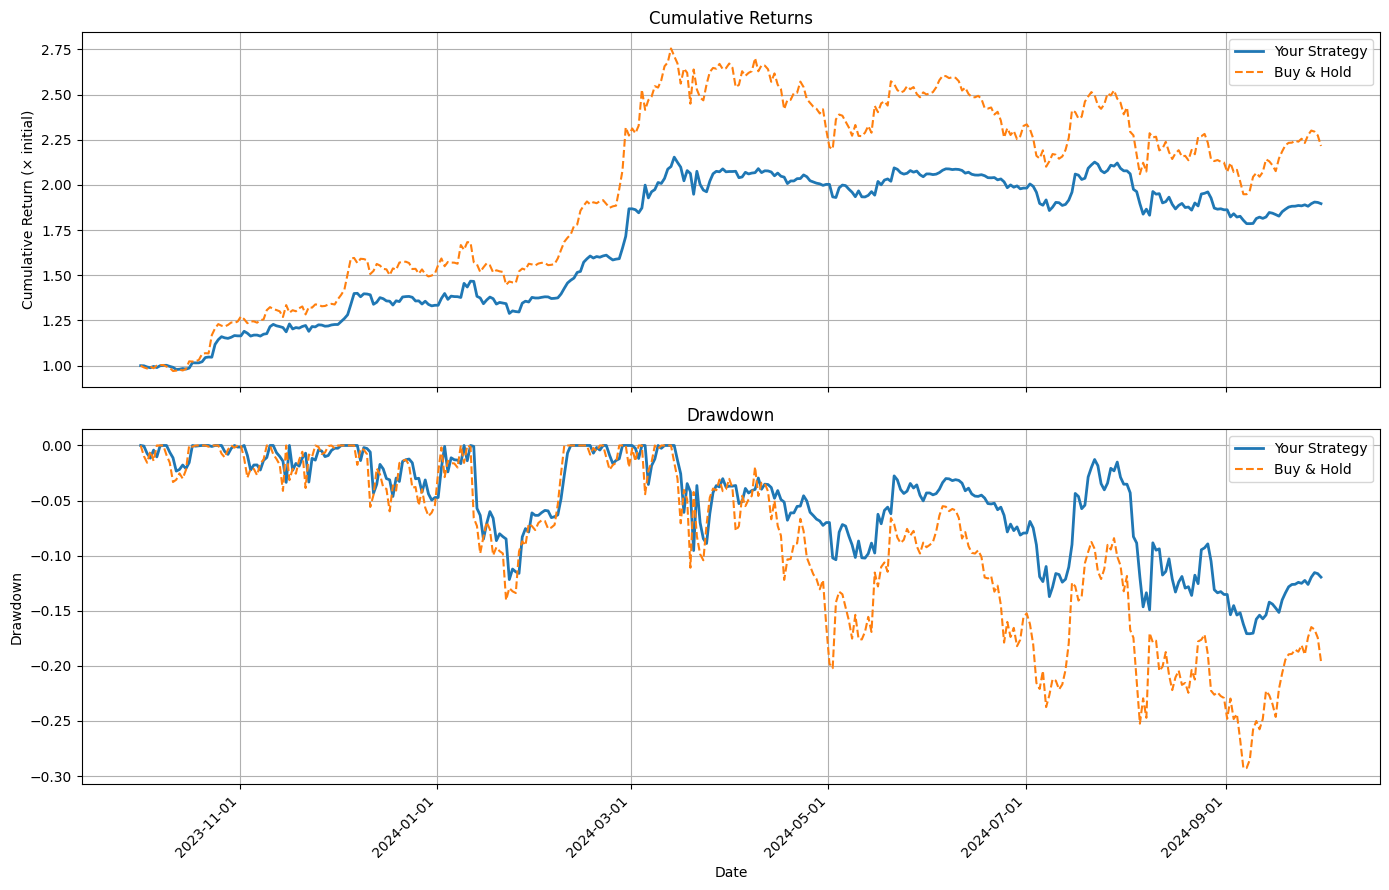

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) CSV 불러오기 + datetime 파싱
strategy_df = pd.read_csv('/home/tako/Documents/yonghan/Macro-Micro-Trader/data/results/total/trade/btc_total.csv')
strategy_df['datetime'] = pd.to_datetime(strategy_df['datetime'])
strategy_df.set_index('datetime', inplace=True)

price_df = pd.read_csv('/home/tako/Documents/yonghan/Macro-Micro-Trader/data/btc_day1.csv')
price_df['datetime'] = pd.to_datetime(price_df['datetime'])
price_df.set_index('datetime', inplace=True)

# 2) 전략 기간(start~end)에 맞춰 Buy&Hold 자르고, 전략의 인덱스로 재색인(ffill)
start, end = strategy_df.index.min(), strategy_df.index.max()
price_slice   = price_df.loc[start:end]
price_aligned = price_slice.reindex(strategy_df.index, method='ffill')

# 3) 누적수익률과 드로우다운 계산
# 3-A) 전략 (return이 % 단위라고 가정)
strategy_df['cum_return']  = 1 + strategy_df['return'] / 100
strategy_df['running_max'] = strategy_df['cum_return'].cummax()
strategy_df['drawdown']    = strategy_df['cum_return'] / strategy_df['running_max'] - 1

# 3-B) Buy&Hold
price_aligned['daily_ret']    = price_aligned['close'].pct_change().fillna(0)
price_aligned['cum_return']   = (1 + price_aligned['daily_ret']).cumprod()
price_aligned['running_max']  = price_aligned['cum_return'].cummax()
price_aligned['drawdown']     = price_aligned['cum_return'] / price_aligned['running_max'] - 1

# 4) 그래프 그리기
fig, axes = plt.subplots(2, 1, figsize=(14,  9), sharex=True)

# (A) 누적수익률
axes[0].plot(strategy_df.index,   strategy_df['cum_return'],
             label='Your Strategy', linewidth=2)
axes[0].plot(price_aligned.index, price_aligned['cum_return'],
             label='Buy & Hold',   linestyle='--')
axes[0].set_title('Cumulative Returns')
axes[0].set_ylabel('Cumulative Return (× initial)')
axes[0].legend(loc='best')
axes[0].grid(True)

# (B) 드로우다운
axes[1].plot(strategy_df.index,   strategy_df['drawdown'],
             label='Your Strategy', linewidth=2)
axes[1].plot(price_aligned.index, price_aligned['drawdown'],
             label='Buy & Hold',   linestyle='--')
axes[1].set_title('Drawdown')
axes[1].set_ylabel('Drawdown')
axes[1].set_xlabel('Date')
axes[1].legend(loc='best')
axes[1].grid(True)

# 5) x축을 실제 날짜로 포맷하고, y축은 플레인 숫자로
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()


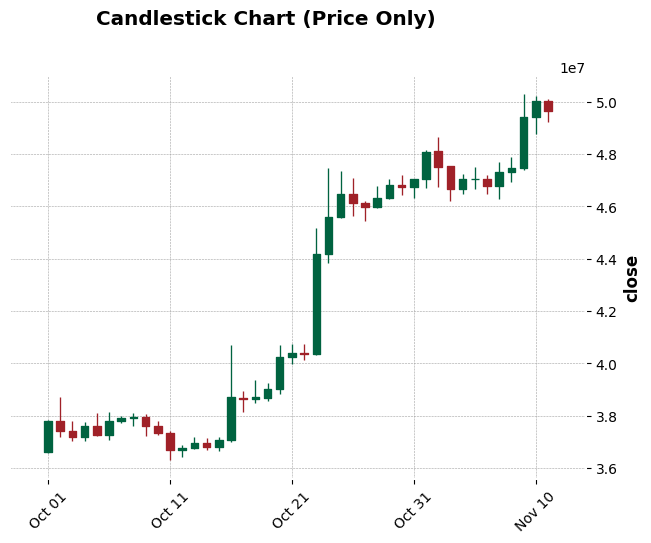

In [1]:
import pandas as pd
import mplfinance as mpf

# 예시 데이터 불러오기 (Date, Open, High, Low, Close, Volume)
df = pd.read_csv('/home/tako/Documents/yonghan/Macro-Micro-Trader/data/btc_day1.csv', index_col=0, parse_dates=True)
df = df.loc['2023-10-01':'2023-11-11']  # 원하는 기간으로 슬라이싱

# 캔들 차트 그리기
mpf.plot(
    df,
    type='candle',
    style='charles',
    title='Candlestick Chart (Price Only)',
    ylabel='close',
    volume=False
)


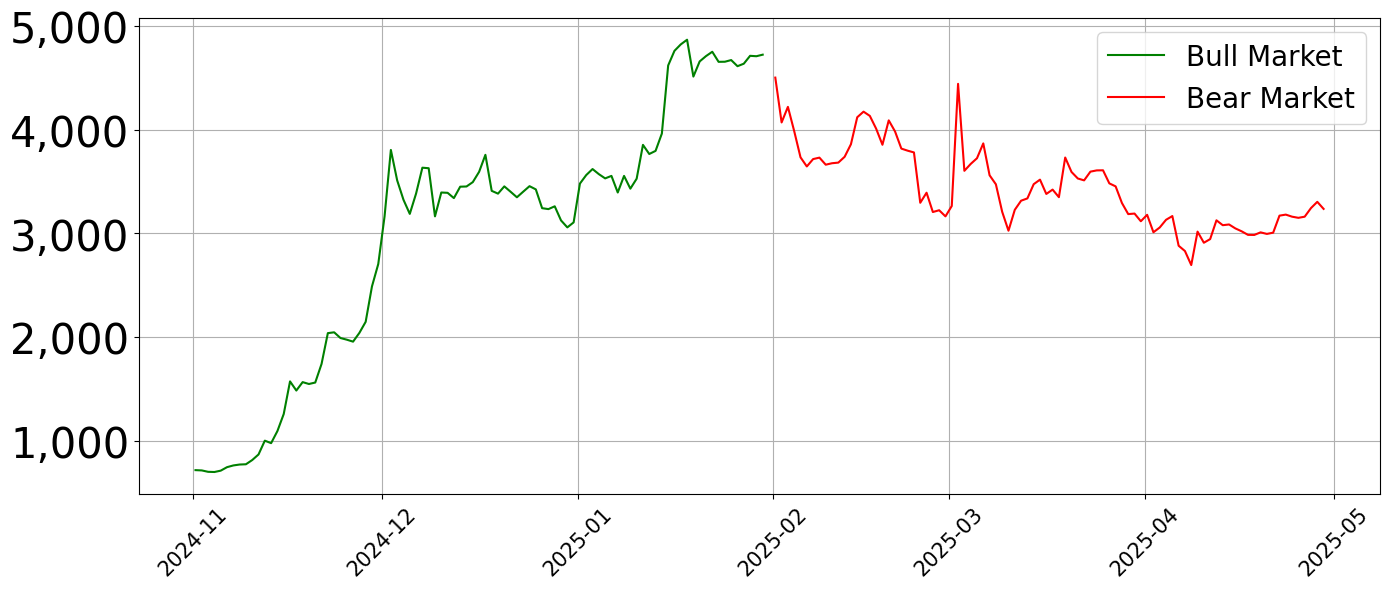

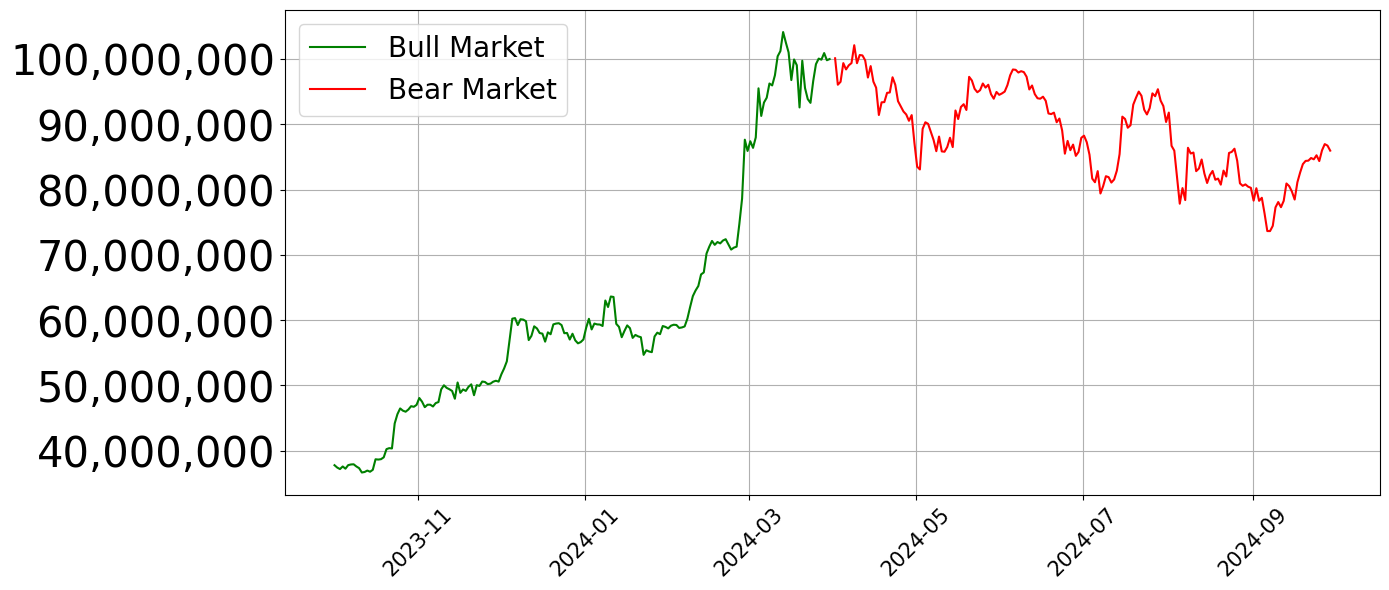

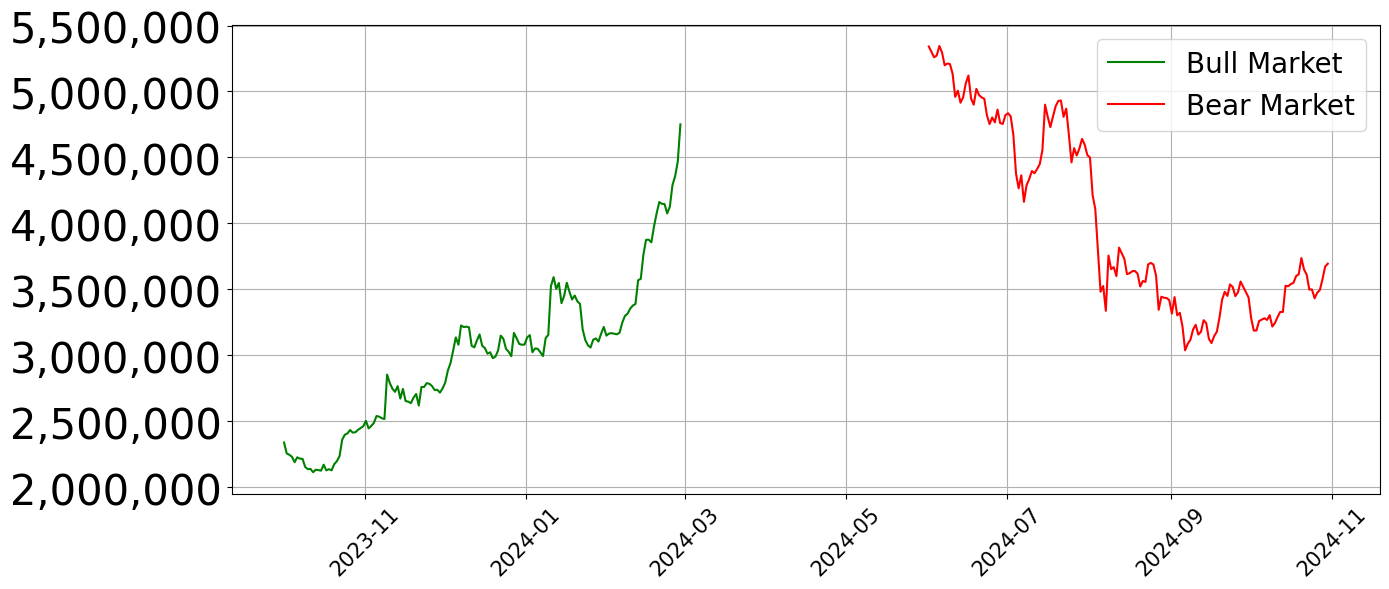

In [17]:
import pyupbit
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def get_coin_data(ticker, start_date, end_date):
    df = pyupbit.get_ohlcv(ticker, interval="day", to=end_date)
    df = df[df.index >= pd.to_datetime(start_date)]
    return df

def format_with_commas(x, pos):
    return f"{int(x):,}"

def plot_segmented_graph(ticker, segments):
    plt.figure(figsize=(14, 6))
    colors = ['green', 'red', 'blue', 'orange', 'purple']
    labels = ['Bull Market', 'Bear Market']
    for i, (start, end) in enumerate(segments):
        df = get_coin_data(ticker, start, end)
        plt.plot(df.index, df['close'], label=labels[i], color=colors[i % len(colors)])

     # y축 숫자 형식을 천 단위 쉼표로 변경
    formatter = FuncFormatter(format_with_commas)
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.xticks(fontsize=15, rotation=45)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 예시: 사용자 입력 구간
xrp_segments = [("2024-11-01", "2025-01-31"), ("2025-02-01", "2025-04-30")]
eth_segments = [("2023-10-01", "2024-02-29"), ("2024-06-01", "2024-10-31")]
btc_segments = [("2023-10-01", "2024-03-31"), ("2024-04-01", "2024-09-30")]

# 실행: 원하는 코인과 구간 입력
plot_segmented_graph("KRW-XRP", xrp_segments)
plot_segmented_graph("KRW-BTC", btc_segments)
plot_segmented_graph("KRW-ETH", eth_segments)
